In [1]:
from numba.core.extending import get_cython_function_address
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import pytz
import pvlib

In [10]:
months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
          '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
          '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
          '2021-01']

years = ['2018', '2019', '2020', '2021']

main_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/CLEAN/"  


In [3]:
ghiFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin',
                                 'F_GHIP_SI02pt100', 'F_GHIP_SMP11', 'F_GHIP_SMP22', 
                                 'F_GHIP_SPN1', 'F_GHIT_SMP22'])

difFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin'
                                  'F_DfHIP_SPN1', 'F_DfHIRP_SMP11', 'F_DfHIT_SMP22',
                                  'DIF_GLO_REF_SPN1'])  

dniFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', 'F_DNI_SHP1'])

In [4]:
location = pvlib.location.Location(-27.430891, -48.441406, tz = 'Brazil/East',altitude= 2.74, name = 'Florianopolis')  # check for daylight savings 'Etc/GMT-3' 'America/Sao_Paulo'

missing = pd.DataFrame(columns= ['days'], index = years) # count data record missing in a year, for each year.

PPmin = -4  # minimum physically possible limit
ERmin = -2  # minimum extremely rare limit


In [8]:
year = years[3]

In [11]:
dfghi = pd.read_pickle(main_path+year+'GHI.pkl')

In [12]:
dfghi

,GHIP_SI02pt100,GHIP_SMP11,GHIP_SMP22,GHIP_SPN1,GHIT_SMP22
TIMESTAMP,,,,,
2021-01-01 00:00:00,0.0,-4.8,0.6,2.284,-1.0
2021-01-01 00:00:01,0.0,-4.8,0.6,2.260,-1.0
2021-01-01 00:00:02,0.0,-4.8,0.6,2.775,-1.0
2021-01-01 00:00:05,0.0,-4.8,0.6,3.692,-1.0
2021-01-01 00:00:06,0.0,-4.8,0.6,3.077,-1.0
...,...,...,...,...,...
2021-01-21 14:25:04,180.1,166.1,171.9,177.000,142.0
2021-01-21 14:25:05,180.0,166.0,171.8,176.900,142.0
2021-01-21 14:25:06,179.9,165.9,171.6,176.400,142.0


In [13]:
    dfghi.index = dfghi.index.tz_localize(location.tz)

In [14]:
naive_times = pd.date_range(start = dfghi.index.min(), end = dfghi.index.max(), freq='1s', tz = location.tz)
naive_times = pd.DatetimeIndex(naive_times)   # PROBLEM: WILL HAVE TO DEAL WITH MISSING VALUES

missing.loc[year] = (len(naive_times) - len(dfghi.index))/3600/24

In [15]:
missing

,days
2018,NaN
2019,NaN
2020,NaN
2021,-0.000185


In [16]:
    eth = pvlib.irradiance.get_extra_radiation(naive_times, solar_constant = 1366.1, method = 'nrel').to_frame()
    solpos = pvlib.solarposition.get_solarposition(naive_times, location.latitude, location.longitude, location.altitude, pressure = 101293, temperature = 25)

    #cosSZA = pd.DataFrame(index = naive_times, columns=['caz'])
    cosSZA = np.cos(np.deg2rad(solpos.azimuth)).to_frame()

In [17]:
    ghiFLAG['PPmax'] = eth[0]*1.5*(cosSZA.azimuth**(1.2)) + 100
    ghiFLAG['PPmin'] = PPmin
    ghiFLAG['ERmax'] = eth[0]*1.2*(cosSZA.azimuth**(1.2)) + 50
    ghiFLAG['ERmin'] = ERmin

In [18]:
    ghiFLAG = pd.merge(ghiFLAG, dfghi, left_index = True, right_index = True, how='outer')  # index by naive times. how = 'inner': index by recorded times.


In [19]:
ghiFLAG

,PPmax,PPmin,ERmax,ERmin,F_GHIP_SI02pt100,F_GHIP_SMP11,F_GHIP_SMP22,F_GHIP_SPN1,F_GHIT_SMP22,GHIP_SI02pt100,GHIP_SMP11,GHIP_SMP22,GHIP_SPN1,GHIT_SMP22
2021-01-01 00:00:00-03:00,NaN,-4,NaN,-2,NaN,NaN,NaN,NaN,NaN,0.0,-4.8,0.6,2.284,-1.0
2021-01-01 00:00:01-03:00,NaN,-4,NaN,-2,NaN,NaN,NaN,NaN,NaN,0.0,-4.8,0.6,2.260,-1.0
2021-01-01 00:00:02-03:00,NaN,-4,NaN,-2,NaN,NaN,NaN,NaN,NaN,0.0,-4.8,0.6,2.775,-1.0
2021-01-01 00:00:03-03:00,NaN,-4,NaN,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:00:04-03:00,NaN,-4,NaN,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-21 14:25:04-03:00,333.671023,-4,236.936818,-2,NaN,NaN,NaN,NaN,NaN,180.1,166.1,171.9,177.000,142.0
2021-01-21 14:25:05-03:00,333.580050,-4,236.864040,-2,NaN,NaN,NaN,NaN,NaN,180.0,166.0,171.8,176.900,142.0
2021-01-21 14:25:06-03:00,333.489101,-4,236.791281,-2,NaN,NaN,NaN,NaN,NaN,179.9,165.9,171.6,176.400,142.0
2021-01-21 14:25:07-03:00,333.398174,-4,236.718539,-2,NaN,NaN,NaN,NaN,NaN,179.7,165.8,171.5,177.300,142.0


In [73]:
 conditions = [ ghiFLAG[['GHIP_SI02pt100','GHIT_SMP22']].isna(), 
                    ghiFLAG[['GHIP_SI02pt100','GHIT_SMP22']]== -9999, 
                    ghiFLAG[['GHIP_SI02pt100','GHIT_SMP22']] < ghiFLAG['PPmin'],
                   (ghiFLAG[['GHIP_SI02pt100','GHIT_SMP22']] > ghiFLAG['PPmin']) & (ghiFLAG[['GHIP_SI02pt100','GHIT_SMP22']]< ghiFLAG['ERmin']),
                   (ghiFLAG[['GHIP_SI02pt100','GHIT_SMP22']] > ghiFLAG['ERmax']) & (ghiFLAG[['GHIP_SI02pt100','GHIT_SMP22']]< ghiFLAG['PPmax']),
                    ghiFLAG[['GHIP_SI02pt100','GHIT_SMP22']] > ghiFLAG['PPmax']]

<ipython-input-73-d78b93731df1>:3: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ghiFLAG[['GHIP_SI02pt100','GHIT_SMP22']] < ghiFLAG['PPmin'],


TypeError: '<' not supported between instances of 'Timestamp' and 'str'

In [45]:
 flags = [-1,
          -1, 
           3,
           1,
           2,
           4]

In [46]:
    ghiFLAG['F_GHIP_SI02pt100':] = np.select(conditions, flags, 0)

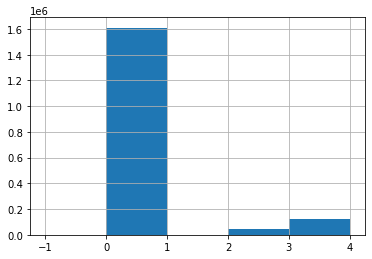

In [49]:
howmany = ghiFLAG['F_GHIP_SI02pt100'].hist(bins = [-1,0,1,2,3,4])

In [43]:
ghiFLAG['GHIP_SI02pt100'].isna()

2021-01-01 00:00:00-03:00    False
2021-01-01 00:00:01-03:00    False
2021-01-01 00:00:02-03:00    False
2021-01-01 00:00:03-03:00     True
2021-01-01 00:00:04-03:00     True
                             ...  
2021-01-21 14:25:04-03:00    False
2021-01-21 14:25:05-03:00    False
2021-01-21 14:25:06-03:00    False
2021-01-21 14:25:07-03:00    False
2021-01-21 14:25:08-03:00    False
Name: GHIP_SI02pt100, Length: 1779929, dtype: bool

In [48]:
ghiFLAG['F_GHIP_SI02pt100'].head(10)

2021-01-01 00:00:00-03:00    0
2021-01-01 00:00:01-03:00    0
2021-01-01 00:00:02-03:00    0
2021-01-01 00:00:03-03:00   -1
2021-01-01 00:00:04-03:00   -1
2021-01-01 00:00:05-03:00    0
2021-01-01 00:00:06-03:00    0
2021-01-01 00:00:07-03:00    0
2021-01-01 00:00:08-03:00    0
2021-01-01 00:00:09-03:00    0
Name: F_GHIP_SI02pt100, dtype: int64

In [51]:
ghiFLAG['F_GHIP_SI02pt100'].value_counts()

 0    1610221
 4     126191
 2      43513
-1          4
Name: F_GHIP_SI02pt100, dtype: int64

<AxesSubplot:>

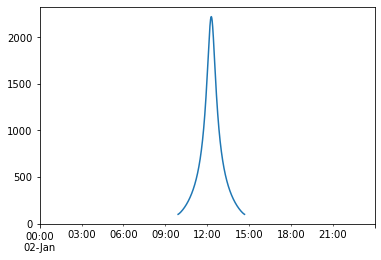

In [58]:
 ghiFLAG['PPmax'].loc['2021-01-02'].plot()

<AxesSubplot:>

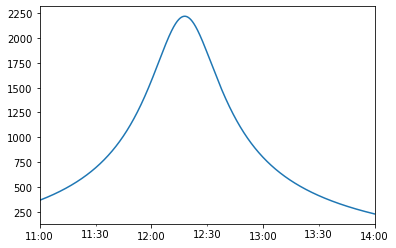

In [59]:
 ghiFLAG['PPmax'].loc['2021-01-02 11:00:00-03:00':'2021-01-02 14:00:00-03:00'].plot()


<AxesSubplot:>

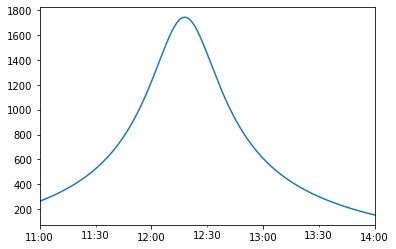

In [62]:
 ghiFLAG['ERmax'].loc['2021-01-02 11:00:00-03:00':'2021-01-02 14:00:00-03:00'].plot()


<AxesSubplot:>

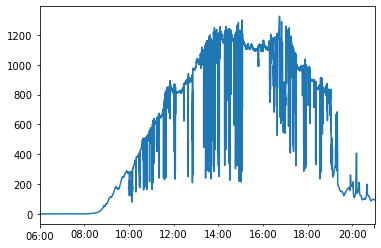

In [67]:
ghiFLAG['GHIP_SI02pt100'].loc['2021-01-03 06:00:00-03:00':'2021-01-03 21:00:00-03:00'].plot()

<AxesSubplot:>

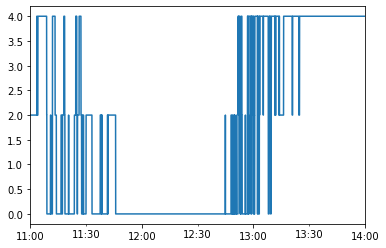

In [61]:
ghiFLAG['F_GHIP_SI02pt100'].loc['2021-01-02 11:00:00-03:00':'2021-01-02 14:00:00-03:00'].plot()

In [72]:
ghiFLAG[['GHIP_SI02pt100','GHIT_SMP22']]

,GHIP_SI02pt100,GHIT_SMP22
2021-01-01 00:00:00-03:00,0.0,-1.0
2021-01-01 00:00:01-03:00,0.0,-1.0
2021-01-01 00:00:02-03:00,0.0,-1.0
2021-01-01 00:00:03-03:00,NaN,NaN
2021-01-01 00:00:04-03:00,NaN,NaN
...,...,...
2021-01-21 14:25:04-03:00,180.1,142.0
2021-01-21 14:25:05-03:00,180.0,142.0
2021-01-21 14:25:06-03:00,179.9,142.0
2021-01-21 14:25:07-03:00,179.7,142.0


In [74]:
ghi =  ['GHIP_SI02pt100',
        'GHIP_SMP11',
        'GHIP_SMP22',
        'GHIP_SPN1',
        'GHIT_SMP22']

In [76]:
            flagcolumn = 'F_'+ ghi[1]


In [77]:
flagcolumn

'F_GHIP_SMP11'

In [78]:
 for column in ghi:
            conditions = [ ghiFLAG[column].isna(), 
            ghiFLAG[column]== -9999, 
            ghiFLAG[column] < ghiFLAG['PPmin'],
            (ghiFLAG[column] > ghiFLAG['PPmin']) & (ghiFLAG[column]< ghiFLAG['ERmin']),
            (ghiFLAG[column] > ghiFLAG['ERmax']) & (ghiFLAG[column]< ghiFLAG['PPmax']),
            ghiFLAG[column] > ghiFLAG['PPmax']]

            flagcolumn = 'F_'+column

            ghiFLAG[flagcolumn] = np.select(conditions, flags, 0)

In [79]:
ghiFLAG

,PPmax,PPmin,ERmax,ERmin,F_GHIP_SI02pt100,F_GHIP_SMP11,F_GHIP_SMP22,F_GHIP_SPN1,F_GHIT_SMP22,GHIP_SI02pt100,GHIP_SMP11,GHIP_SMP22,GHIP_SPN1,GHIT_SMP22
2021-01-01 00:00:00-03:00,NaN,-4,NaN,-2,0,3,0,0,0,0.0,-4.8,0.6,2.284,-1.0
2021-01-01 00:00:01-03:00,NaN,-4,NaN,-2,0,3,0,0,0,0.0,-4.8,0.6,2.260,-1.0
2021-01-01 00:00:02-03:00,NaN,-4,NaN,-2,0,3,0,0,0,0.0,-4.8,0.6,2.775,-1.0
2021-01-01 00:00:03-03:00,NaN,-4,NaN,-2,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:00:04-03:00,NaN,-4,NaN,-2,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-21 14:25:04-03:00,333.671023,-4,236.936818,-2,0,0,0,0,0,180.1,166.1,171.9,177.000,142.0
2021-01-21 14:25:05-03:00,333.580050,-4,236.864040,-2,0,0,0,0,0,180.0,166.0,171.8,176.900,142.0
2021-01-21 14:25:06-03:00,333.489101,-4,236.791281,-2,0,0,0,0,0,179.9,165.9,171.6,176.400,142.0
2021-01-21 14:25:07-03:00,333.398174,-4,236.718539,-2,0,0,0,0,0,179.7,165.8,171.5,177.300,142.0


In [80]:
ghiFLAG['F_GHIP_SI02pt100'].value_counts()

 0    1610221
 4     126191
 2      43513
-1          4
Name: F_GHIP_SI02pt100, dtype: int64

In [81]:
ghiFLAG['F_GHIP_SMP11'].value_counts()

 0    842541
 3    638487
 1    129640
 4    129262
 2     39995
-1         4
Name: F_GHIP_SMP11, dtype: int64

In [82]:
ghiFLAG['F_GHIP_SMP11'].value_counts()

 0    842541
 3    638487
 1    129640
 4    129262
 2     39995
-1         4
Name: F_GHIP_SMP11, dtype: int64

In [83]:
 ghiFLAG['F_GHIP_SMP22'].value_counts()

 0    1606396
 4     130866
 2      42663
-1          4
Name: F_GHIP_SMP22, dtype: int64

In [92]:
b= ghiFLAG['F_GHIP_SPN1'].value_counts()

In [87]:
a = ghiFLAG['F_GHIT_SMP22'].value_counts()

In [88]:
a

 0    1594507
 4      54617
 1      54427
 2      41080
 3      35294
-1          4
Name: F_GHIT_SMP22, dtype: int64

In [90]:
ghiflagcount['GHIT_SMP22'] = a

In [93]:
ghiflagcount['GHIP_SPN1']= b

In [85]:
ghiFLAG['F_GHIT_SMP22'].value_counts()

 0    1594507
 4      54617
 1      54427
 2      41080
 3      35294
-1          4
Name: F_GHIT_SMP22, dtype: int64

In [85]:
ghiFLAG['F_GHIT_SMP22'].value_counts()

 0    1594507
 4      54617
 1      54427
 2      41080
 3      35294
-1          4
Name: F_GHIT_SMP22, dtype: int64

In [85]:
ghiFLAG['F_GHIT_SMP22'].value_counts()

 0    1594507
 4      54617
 1      54427
 2      41080
 3      35294
-1          4
Name: F_GHIT_SMP22, dtype: int64

In [95]:
ghiflagcount.dtypes


GHIP_SI02pt100     object
GHIP_SMP11         object
GHIP_SMP22         object
GHIP_SPN1         float64
GHIT_SMP22          int64
dtype: object

In [96]:
ghiFLAG.dtypes

PPmax               float64
PPmin                 int64
ERmax               float64
ERmin                 int64
F_GHIP_SI02pt100      int64
F_GHIP_SMP11          int64
F_GHIP_SMP22          int64
F_GHIP_SPN1           int64
F_GHIT_SMP22          int64
GHIP_SI02pt100      float64
GHIP_SMP11          float64
GHIP_SMP22          float64
GHIP_SPN1           float64
GHIT_SMP22          float64
dtype: object

In [86]:
ghiflagcount = pd.DataFrame(columns= [ghi], index = [-1, 0, 1, 2, 3, 4]) 
